In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary

from PIL import Image
import os
import re

import torchvision.transforms.functional as TF

import pandas as pd

In [0]:
transform = transforms.Compose(
    [transforms.Resize(100),
     transforms.RandomHorizontalFlip(p=0.5), # data augmentation by fliping 
     transforms.ToTensor(),    # range [0, 255] -> [0.0,1.0]
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # channel=（channel-mean）/std  -> [-1, 1]


# if the image has only one channel (grayscale), normalise operation will be 
# transforms.Normalize((0.5, ), (0.5, ))

In [0]:
def load_images_from_folder(folder):
    images = []
    
    for filename in os.listdir(folder):
        
        if re.match(r'.*jpg$', filename):
            if re.match(r'^re_', filename):
                print(filename)
                continue
            
            if re.match(r'^re_', filename):
                print(filename)
                
            img = Image.open(os.path.join(folder,filename)).convert('RGB')
            #print(filename)
            images.append((filename.split('.')[0], transform(img)))
            img.close()
        
    return images

In [0]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("./drive/My Drive/images.zip", "r")
zip_ref.extractall()
zip_ref.close()

# Define Dataset

In [0]:
import os
import torch
import re
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

In [0]:
class imageDataset(Dataset):

    def __init__(self, folder, df, transform):

        #self.images = images
        #self.tensor_df = pd.DataFrame(images, columns=['imdbId', 'tensor'])
        #self.tensor_df['imdbId'] = self.tensor_df['imdbId'].astype(int)

        self.df_raw = pd.read_csv(df)
        self.folder = folder
        self.transform = transform

        #self.df = pd.merge(self.tensor_df, self.df_raw, on='imdbId', how='inner')

    def __getitem__(self, idx):

        #X = self.df.loc[idx, "tensor"]
        #y = self.df.iloc[idx, 2:].values.astype(int)
        imdbId = self.df_raw.loc[idx, 'imdbId']
        y = self.df_raw.iloc[idx, 1:].values.astype(int)
        filename = str(imdbId) + '.jpg'
        image = Image.open(os.path.join(self.folder,filename), 'r').convert('RGB')

        X = self.transform(image)

        image.close()

        return X, y

    def __len__(self):
        return len(self.df_raw)

In [0]:
train = imageDataset('images' , 
                     './drive/My Drive/pa2_data/part1_data/train.csv', 
                     transform)

In [0]:
test = imageDataset('images', 
                    './drive/My Drive/pa2_data/part1_data/test.csv', 
                    transform)

In [0]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(save_path, model, optimizer):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

def predict_label(outputs, threshold):
    predict = outputs.clone()
    for row in predict:
        for i in range(len(row)):
            if row[i] >= threshold:
                row[i] = 1
            else:
                row[i] = 0
                
    return predict

def multiclass_accuracy(pred, label):
    
    return float(torch.sum(pred == label)) / float((pred.shape[0] * pred.shape[1]))



def TRAIN(net, train_loader, valid_loader,  num_epochs, eval_every, total_step, criterion, 
          optimizer, val_loss, device, save_name):
    train_loss = []
    valid_loss = []
  
    net = net.to(device)
    
    running_loss = 0.0
    running_corrects = 0
    running_num = 0
    global_step = 0
    if val_loss==None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss=val_loss
    

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        for i, (inputs, labels) in enumerate(train_loader):
            net.train() # tell the net the training is started
            inputs = inputs.to(device)
            labels = labels.to(device)

            '''Training of the model'''
            # Forward pass
            outputs = net(inputs)
            #print(outputs.data)
            #print(labels.data)
            
            #pred = torch.
            #print(outputs.data)
            pred = predict_label(outputs.data, 0.5)
            #print(pred)

            #print(torch.sum(pred.data == labels.data))
            #print(outputs)
            # print("-------------------------------------------------")
            #_, preds = torch.max(outputs.data, 1) this is originally to output the maximum probability indice
            #print(torch.max(outputs.data, 1)) 
            #print(preds)
            #print(outputs.data)
            labels = labels.type_as(outputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            global_step += 1

            running_loss += loss.item()
            running_corrects += torch.sum(pred == labels)
            running_num += (labels.shape[0] * labels.shape[1])

            '''Evaluating the model every x steps'''
            if global_step % eval_every == 0:
                with torch.no_grad():
                    net.eval()
                    val_running_loss = 0.0
                    val_running_corrects = 0
                    for val_inputs, val_labels in valid_loader:
                        val_inputs = val_inputs.to(device)
                        val_labels = val_labels.to(device)

                        val_outputs = net(val_inputs)
                        val_labels = val_labels.type_as(val_outputs)
                        val_loss = criterion(val_outputs, val_labels)

                        #_, preds = torch.max(val_outputs.data, 1)
                        val_pred = predict_label(val_outputs.data, 0.5)
                        val_running_loss += val_loss.item()
                        val_running_corrects += multiclass_accuracy(val_pred, val_labels)


                    average_train_loss = running_loss / eval_every
                    average_val_loss = val_running_loss / len(valid_loader)

                    train_loss.append(average_train_loss)
                    valid_loss.append(average_val_loss)

                    average_train_acc = running_corrects / float(running_num)
                    average_val_acc = val_running_corrects / float(len(valid_loader))

                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},\
                    Valid Acc: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, total_step, average_train_loss,
                                  average_train_acc, average_val_loss, average_val_acc))

                    running_loss = 0.0
                    running_num = 0
                    running_corrects = 0
                    
                    if average_val_loss < best_val_loss:
                        best_val_loss = average_val_loss
                        print(best_val_loss)
                        save_checkpoint(save_name, net, optimizer, best_val_loss)
                    
                    
    print('Finished Training')
    return train_loss, valid_loss

# Define CNN

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,  kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3) 
        self.fc1 = nn.Linear(256 * 6 * 3, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 7)
        self.bn1 = nn.BatchNorm1d(256 * 6 * 3)
        self.bn2 = nn.BatchNorm1d(100)
        self.bn3 = nn.BatchNorm1d(50)
        self.bn2_1 = nn.BatchNorm2d(32)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.bn2_3 = nn.BatchNorm2d(128)
        self.bn2_4 = nn.BatchNorm2d(128, 33 * 22)
        self.drop1 = nn.Dropout(0.25)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #  3, 47, 32
        # out_dim = in_dim - kernel_size + 1  
        x = F.relu(self.conv1(x)) #6, 21, 14
        x = self.bn2_1(x) 
        x = self.pool(F.relu(self.conv2(x))) #16, 8, 5
        x = self.drop1(x)
        x = self.bn2_2(x)
        x = self.pool(F.relu(self.conv3(x))) #10, 25, 6
        x = self.drop1(x)
        x = self.pool(F.relu(self.conv4(x))) # 6, 11, 7
        x = self.bn2_3(x)
        x = self.pool(F.relu(self.conv5(x)))
        #x = F.relu(self.conv6(x))
        #x = self.pool(F.relu(self.conv7(x)))
        #x = self.bn2_4(x)
        x = x.view(-1, 256 * 6 * 3)
        x = self.drop1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.bn3(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# inputs = inputs.to(device)

In [0]:
batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size,
                          shuffle=True, num_workers=1)

valid_loader = DataLoader(test, batch_size=batch_size,
                          shuffle=True, num_workers=1)

test_loader = DataLoader(test, batch_size=1,
                         shuffle=True, num_workers=1)

dataiter = iter(test_loader)
inputs, labels = dataiter.next()

print(f'Batched features:\n {inputs, inputs.shape}, \
      \n Batched labels:\n {labels}')

Batched features:
 (tensor([[[[-0.7804, -0.8039, -0.7961,  ..., -0.8588, -0.7412, -0.8118],
          [-0.7725, -0.8510, -0.8118,  ..., -0.9216, -0.8118, -0.7725],
          [-0.4667, -0.3725, -0.2627,  ..., -0.2941, -0.0275,  0.0353],
          ...,
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843]],

         [[-0.2314, -0.2314, -0.2471,  ..., -0.5216, -0.2000, -0.2314],
          [-0.1686, -0.2941, -0.2706,  ..., -0.5059, -0.2000, -0.1373],
          [-0.1922, -0.1529, -0.0980,  ..., -0.2235,  0.1059,  0.2000],
          ...,
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843]],

         [[-0.8118, -0.9216, -0.8667,  ..., -0.8745, -0.8667, -0.9216],
          

In [0]:
model = Net()
model = model.to(device)
summary(model, input_size=(3, 147, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 143, 96]           2,432
       BatchNorm2d-2          [-1, 32, 143, 96]              64
            Conv2d-3          [-1, 64, 139, 92]          51,264
         MaxPool2d-4           [-1, 64, 69, 46]               0
           Dropout-5           [-1, 64, 69, 46]               0
       BatchNorm2d-6           [-1, 64, 69, 46]             128
            Conv2d-7           [-1, 64, 65, 42]         102,464
         MaxPool2d-8           [-1, 64, 32, 21]               0
           Dropout-9           [-1, 64, 32, 21]               0
           Conv2d-10          [-1, 128, 30, 19]          73,856
        MaxPool2d-11           [-1, 128, 15, 9]               0
      BatchNorm2d-12           [-1, 128, 15, 9]             256
           Conv2d-13           [-1, 256, 13, 7]         295,168
        MaxPool2d-14            [-1, 25

In [0]:
num_epochs = 10
eval_every = 30
total_step = len(train_loader)*num_epochs
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)
save_path = f'cnn.pt'
device = torch.device('cuda:0')
model = model.to(device)

train_loss, valid_loss = TRAIN(model, train_loader, valid_loader, num_epochs, eval_every, total_step, criterion, 
      optimizer, best_val_loss, device, save_path)

Epoch [1/10], Step [30/810], Train Loss: 0.6584, Train Acc: 0.6128, Valid Loss: 0.5996,                    Valid Acc: 0.6889
0.5995551198720932
Model saved to ==> cnn.pt
Epoch [1/10], Step [60/810], Train Loss: 0.5216, Train Acc: 0.7645, Valid Loss: 0.4715,                    Valid Acc: 0.7775
0.47146518528461456
Model saved to ==> cnn.pt
Epoch [2/10], Step [90/810], Train Loss: 0.4695, Train Acc: 0.7825, Valid Loss: 0.4652,                    Valid Acc: 0.7807
0.4651519227772951
Model saved to ==> cnn.pt
Epoch [2/10], Step [120/810], Train Loss: 0.4674, Train Acc: 0.7842, Valid Loss: 0.4656,                    Valid Acc: 0.7856
Epoch [2/10], Step [150/810], Train Loss: 0.4651, Train Acc: 0.7850, Valid Loss: 0.4697,                    Valid Acc: 0.7781
Epoch [3/10], Step [180/810], Train Loss: 0.4605, Train Acc: 0.7851, Valid Loss: 0.4654,                    Valid Acc: 0.7893
Epoch [3/10], Step [210/810], Train Loss: 0.4584, Train Acc: 0.7895, Valid Loss: 0.4630,                    Val

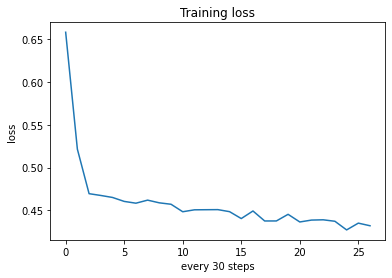

In [0]:
plt.plot(train_loss)
plt.xlabel("every 30 steps")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()

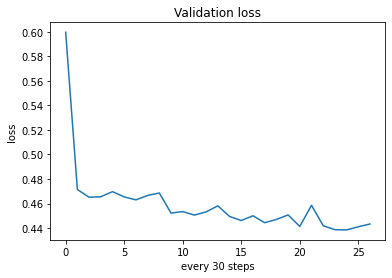

In [0]:
plt.plot(valid_loss)
plt.xlabel("every 30 steps")
plt.ylabel("loss")
plt.title("Validation loss")
plt.show()

# Hyperparameter setting

In [0]:
batch_size = 32

train_loader = DataLoader(train, batch_size=batch_size,
                          shuffle=True, num_workers=1)

valid_loader = DataLoader(test, batch_size=batch_size,
                          shuffle=True, num_workers=1)

test_loader = DataLoader(test, batch_size=1,
                         shuffle=True, num_workers=1)

dataiter = iter(test_loader)
inputs, labels = dataiter.next()

print(f'Batched features:\n {inputs, inputs.shape}, \
      \n Batched labels:\n {labels}')

Batched features:
 (tensor([[[[ 0.2235,  0.2157,  0.2078,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.2392,  0.2784,  0.3020,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.2863,  0.3412,  0.3647,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.2314, -0.2549, -0.2235,  ..., -1.0000, -1.0000, -1.0000],
          [-0.2392, -0.2314, -0.1922,  ..., -1.0000, -1.0000, -1.0000],
          [-0.2941, -0.2549, -0.1843,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.1843,  0.1765,  0.1686,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.2000,  0.2392,  0.2627,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.2471,  0.3020,  0.3255,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.9686, -0.9843, -0.9686,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9686, -0.9922, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9922, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.1529,  0.1451,  0.1373,  ..., -1.0000, -1.0000, -1.0000],
          

In [0]:
model = Net()
model = model.to(device)
summary(model, input_size=(3, 147, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 143, 96]           2,432
       BatchNorm2d-2          [-1, 32, 143, 96]              64
            Conv2d-3          [-1, 64, 139, 92]          51,264
         MaxPool2d-4           [-1, 64, 69, 46]               0
           Dropout-5           [-1, 64, 69, 46]               0
       BatchNorm2d-6           [-1, 64, 69, 46]             128
            Conv2d-7           [-1, 64, 65, 42]         102,464
         MaxPool2d-8           [-1, 64, 32, 21]               0
           Dropout-9           [-1, 64, 32, 21]               0
           Conv2d-10          [-1, 128, 30, 19]          73,856
        MaxPool2d-11           [-1, 128, 15, 9]               0
      BatchNorm2d-12           [-1, 128, 15, 9]             256
           Conv2d-13           [-1, 256, 13, 7]         295,168
        MaxPool2d-14            [-1, 25

In [0]:
num_epochs = 10
eval_every = 30
total_step = len(train_loader)*num_epochs
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
save_path = f'cnn.pt'
device = torch.device('cuda:0')
model = model.to(device)

train_loss, valid_loss = TRAIN(model, train_loader, valid_loader, num_epochs, eval_every, total_step, criterion, 
      optimizer, best_val_loss, device, save_path)

Epoch [1/10], Step [30/3240], Train Loss: 0.7092, Train Acc: 0.5249, Valid Loss: 0.6721,                    Valid Acc: 0.5717
0.6721068251700628
Model saved to ==> cnn.pt
Epoch [1/10], Step [60/3240], Train Loss: 0.6770, Train Acc: 0.5649, Valid Loss: 0.6444,                    Valid Acc: 0.6502
0.6443908148341708
Model saved to ==> cnn.pt
Epoch [1/10], Step [90/3240], Train Loss: 0.6500, Train Acc: 0.6354, Valid Loss: 0.6281,                    Valid Acc: 0.7221
0.6281324502021547
Model saved to ==> cnn.pt
Epoch [1/10], Step [120/3240], Train Loss: 0.6204, Train Acc: 0.6894, Valid Loss: 0.6073,                    Valid Acc: 0.7166
0.6072584456867642
Model saved to ==> cnn.pt
Epoch [1/10], Step [150/3240], Train Loss: 0.5803, Train Acc: 0.7330, Valid Loss: 0.5524,                    Valid Acc: 0.7713
0.5523807860556103
Model saved to ==> cnn.pt
Epoch [1/10], Step [180/3240], Train Loss: 0.5422, Train Acc: 0.7626, Valid Loss: 0.5192,                    Valid Acc: 0.7776
0.51923349073954

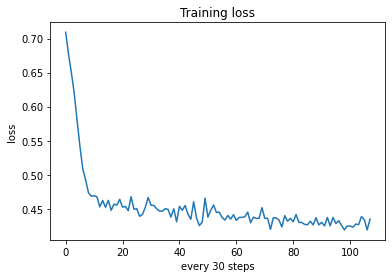

In [0]:
plt.plot(train_loss)
plt.xlabel("every 30 steps")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()

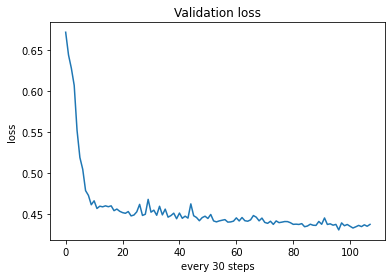

In [0]:
plt.plot(valid_loss)
plt.xlabel("every 30 steps")
plt.ylabel("loss")
plt.title("Validation loss")
plt.show()

# Train 10 more epochs before testing

In [0]:
train_loss, valid_loss = TRAIN(model, train_loader, valid_loader, num_epochs, eval_every, total_step, criterion, 
      optimizer, best_val_loss, device, save_path)

Epoch [1/10], Step [30/3240], Train Loss: 0.4238, Train Acc: 0.8040, Valid Loss: 0.4330,                    Valid Acc: 0.8030
0.43304214401850627
Model saved to ==> cnn.pt
Epoch [1/10], Step [60/3240], Train Loss: 0.4276, Train Acc: 0.8027, Valid Loss: 0.4312,                    Valid Acc: 0.8029
0.4311834095962464
Model saved to ==> cnn.pt
Epoch [1/10], Step [90/3240], Train Loss: 0.4300, Train Acc: 0.8021, Valid Loss: 0.4470,                    Valid Acc: 0.7951
Epoch [1/10], Step [120/3240], Train Loss: 0.4273, Train Acc: 0.8019, Valid Loss: 0.4421,                    Valid Acc: 0.7980
Epoch [1/10], Step [150/3240], Train Loss: 0.4243, Train Acc: 0.8004, Valid Loss: 0.4319,                    Valid Acc: 0.8032
Epoch [1/10], Step [180/3240], Train Loss: 0.4178, Train Acc: 0.8115, Valid Loss: 0.4375,                    Valid Acc: 0.8002
Epoch [1/10], Step [210/3240], Train Loss: 0.4200, Train Acc: 0.8141, Valid Loss: 0.4336,                    Valid Acc: 0.8028
Epoch [1/10], Step [240

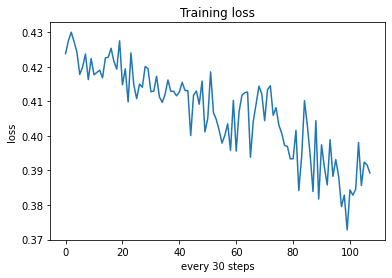

In [0]:
plt.plot(train_loss)
plt.xlabel("every 30 steps")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()

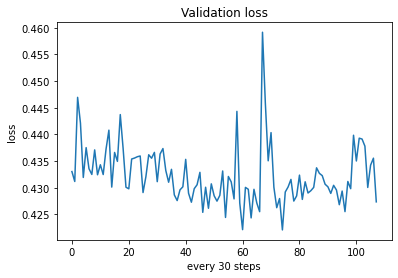

In [0]:
plt.plot(valid_loss)
plt.xlabel("every 30 steps")
plt.ylabel("loss")
plt.title("Validation loss")
plt.show()

# Classification Report

In [0]:
from sklearn.metrics import classification_report

In [0]:
thetas = [0.3, 0.5, 0.7]

last_epoch = load_checkpoint(f'cnn.pt', model, optimizer)
model.eval()

for theta in thetas:

  y_test = []
  y_pred = []
  
  for test_inputs, test_labels in test_loader:
    with torch.no_grad():
      model.eval()
      test_inputs = test_inputs.to(device)

      #print(test_inputs.shape)
      test_prob = model(test_inputs)
      test_pred = (predict_label(test_prob, theta))
      # print(test_labels, test_prob, test_pred)

      y_test.append(np.array(test_labels).reshape(-1))
      y_pred.append(np.array(test_pred.cpu()).reshape(-1))

  print("\n theta = " + str(theta) + "\n")
  print(classification_report(np.array(y_test), np.array(y_pred)))

Model loaded from <== cnn.pt

 theta = 0.3

              precision    recall  f1-score   support

           0       0.40      0.55      0.46       413
           1       0.35      0.22      0.27       254
           2       0.53      0.32      0.40       148
           3       0.58      0.77      0.66       774
           4       0.60      0.97      0.74      1151
           5       0.38      0.36      0.37       259
           6       0.44      0.47      0.46       418

   micro avg       0.53      0.68      0.60      3417
   macro avg       0.47      0.52      0.48      3417
weighted avg       0.51      0.68      0.58      3417
 samples avg       0.55      0.70      0.59      3417


 theta = 0.5

              precision    recall  f1-score   support

           0       0.60      0.21      0.31       413
           1       0.69      0.04      0.07       254
           2       0.69      0.23      0.35       148
           3       0.71      0.49      0.58       774
           4       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 theta = 0.7

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       413
           1       0.00      0.00      0.00       254
           2       0.82      0.09      0.17       148
           3       0.77      0.23      0.36       774
           4       0.74      0.41      0.52      1151
           5       0.80      0.02      0.03       259
           6       0.33      0.00      0.00       418

   micro avg       0.75      0.20      0.31      3417
   macro avg       0.64      0.11      0.16      3417
weighted avg       0.68      0.20      0.27      3417
 samples avg       0.33      0.22      0.25      3417



# Submission

In [0]:
sub_df = pd.read_csv('./drive/My Drive/pa2_data/part1_data/submission.csv')

for i in range(len(sub_df)):
  movie = sub_df.loc[i, 'imdbId']
  filename = str(movie) + '.jpg'
  image = Image.open(os.path.join('images' ,filename), 'r').convert('RGB')
  X = transform(image)

  image.close()

  sub_inputs = X[None, :, :, :]
  with torch.no_grad():
    model.eval()
    sub_inputs = sub_inputs.to(device)
    sub_prob = model(sub_inputs)
    sub_pred = (predict_label(sub_prob, 0.3))

    sub_df.loc[i, 1:] = np.array(sub_pred.cpu()).reshape(-1)

sub_df

,imdbId,Action,Adventure,Animation,Comedy,Drama,Horror,Romance
0,2960930,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1295071,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,239441,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,305396,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1413489,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
586,3704050,0.0,0.0,0.0,0.0,1.0,0.0,0.0
587,477253,0.0,0.0,0.0,1.0,1.0,0.0,1.0
588,371606,0.0,1.0,1.0,1.0,0.0,0.0,0.0
589,392364,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [0]:
sub_df.to_csv("submission.csv")